In [38]:
import os
import numpy as np
import pandas as pd
from nilearn import masking, image
from scipy.stats import ttest_1samp, pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

## plot ROI mean effect

In [114]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
hp_data = participants_data.query('(game2_fmri>=0.5)')
hp_subjects = hp_data['Participant_ID'].to_list()

# set camp
cmap_template = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game2/cv_hexagon_spct/Setall/6fold/{}/zmap/alignPhi_zmap.nii.gz'

# set roi
for thr in range(1,99,10):
    roi = image.load_img(r'/mnt/workdir/DCM/result/ROI/anat/juelich_EC_MNI152NL_prob_L.nii.gz')
    roi = image.binarize_img(roi,thr)
    tmp_img = r'/mnt/workdir/DCM/result/ROI/anat/cortex/hippocampus/M1_tmap.nii.gz'
    roi = image.resample_to_img(roi,tmp_img,interpolation='nearest')

    # get activity in ROI
    hp_subs_cmap_list = [cmap_template.format(sub_id) for sub_id in hp_subjects]
    hp_subs_mean_activity = np.mean(masking.apply_mask(hp_subs_cmap_list, roi),axis=1)

    # mean
    t_statistic, p_value = ttest_1samp(hp_subs_mean_activity, 0)
    print('t:', t_statistic)
    print('p:', p_value)
#sns.barplot(data=hp_subs_mean_activity, errorbar='sd', width=0.2)  # plot

KeyboardInterrupt: 

## Plot brain activity with age

In [160]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
junv_data = participants_data.query('(game2_fmri>=0.5)and(Age<18)')
adult_data = participants_data.query('(game2_fmri>=0.5)and(Age>=18)')
junv_subjects = junv_data['Participant_ID'].to_list()
adult_subjects = adult_data['Participant_ID'].to_list()
# set camp
cmap_template = r'/mnt/data/DCM/result_backup/2023.3.13/Nilearn/game2/distance_spct/Setall/6fold/{}/zmap/M2_corrxdistance_zmap.nii.gz'

# set roi
roi = image.load_img(r'/mnt/workdir/DCM/result/ROI/anat/juelich_EC_MNI152NL_prob.nii.gz')
roi = image.binarize_img(roi,10)
tmp_img = r'/mnt/workdir/DCM/result/ROI/anat/cortex/hippocampus/M1_tmap.nii.gz'
roi = image.resample_to_img(roi,tmp_img,interpolation='nearest')

# get activity in ROI
junv_subs_cmap_list = [cmap_template.format(sub_id) for sub_id in junv_subjects]
junv_subs_mean_activity = np.mean(masking.apply_mask(junv_subs_cmap_list, roi),axis=1)

adult_subs_cmap_list = [cmap_template.format(sub_id) for sub_id in adult_subjects]
adult_subs_mean_activity = np.mean(masking.apply_mask(adult_subs_cmap_list, roi),axis=1)
# get covariate
junv_covary_variable = junv_data['Age'].to_list()
adult_covary_variable = adult_data['Age'].to_list()

/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


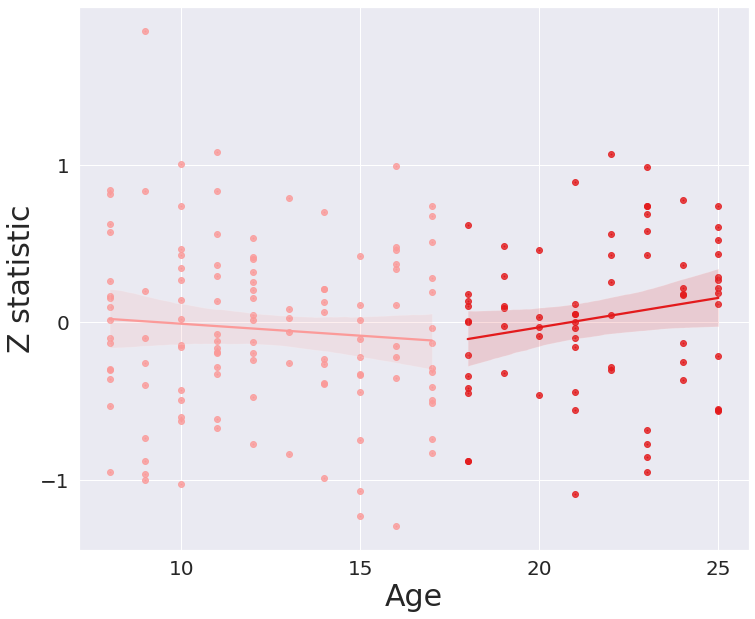

In [161]:
fig, ax = plt.subplots(figsize=(12,10))
color = sns.color_palette("Paired")
plt.scatter(junv_covary_variable, junv_subs_mean_activity,color=color[4],label='junvenal', s=1.)
plt.scatter(adult_covary_variable, adult_subs_mean_activity,color=color[5],label='adult', s=1.)
sns.regplot(x=junv_covary_variable, y=junv_subs_mean_activity,color=color[4])
sns.regplot(x=adult_covary_variable, y=adult_subs_mean_activity,color=color[5])

ax.set_xlabel('Age', fontsize=30)
ax.set_ylabel('Z statistic', fontsize=30)
ax.set_yticks([-1, 0, 1])
ax.set_xticks([10, 15, 20, 25])
ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig(r"/mnt/workdir/DCM/result/game2/distance_age_effect_mPFC.png",dpi=300,bbox_inches='tight',pad_inches=0)

In [174]:
import numpy as np
from scipy.stats import t, norm
from math import atanh, pow
from numpy import tanh

r1,p1 = pearsonr(junv_covary_variable, junv_subs_mean_activity)
r2,p2 = pearsonr(adult_covary_variable, adult_subs_mean_activity)

# Sample sizes for each correlation coefficient
n1 = len(junv_covary_variable)
n2 = len(adult_covary_variable)
print(r1,p1)
print(r2,p2)

def rz_ci(r, n, conf_level = 0.95):
    zr_se = pow(1/(n - 3), .5)
    moe = norm.ppf(1 - (1 - conf_level)/float(2)) * zr_se
    zu = atanh(r) + moe
    zl = atanh(r) - moe
    return tanh((zl, zu))

def independent_corr(xy, ab, n, n2 = None, twotailed=True, conf_level=0.95, method='fisher'):
    """
    Calculates the statistic significance between two independent correlation coefficients
    @param xy: correlation coefficient between x and y
    @param xz: correlation coefficient between a and b
    @param n: number of elements in xy
    @param n2: number of elements in ab (if distinct from n)
    @param twotailed: whether to calculate a one or two tailed test, only works for 'fisher' method
    @param conf_level: confidence level, only works for 'zou' method
    @param method: defines the method uses, 'fisher' or 'zou'
    @return: z and p-val
    """

    if method == 'fisher':
        xy_z = 0.5 * np.log((1 + xy)/(1 - xy))
        ab_z = 0.5 * np.log((1 + ab)/(1 - ab))
        if n2 is None:
            n2 = n

        se_diff_r = np.sqrt(1/(n - 3) + 1/(n2 - 3))
        diff = xy_z - ab_z
        z = abs(diff / se_diff_r)
        p = (1 - norm.cdf(z))
        if twotailed:
            p *= 2

        return z, p
    elif method == 'zou':
        L1 = rz_ci(xy, n, conf_level=conf_level)[0]
        U1 = rz_ci(xy, n, conf_level=conf_level)[1]
        L2 = rz_ci(ab, n2, conf_level=conf_level)[0]
        U2 = rz_ci(ab, n2, conf_level=conf_level)[1]
        lower = xy - ab - pow((pow((xy - L1), 2) + pow((U2 - ab), 2)), 0.5)
        upper = xy - ab + pow((pow((U1 - xy), 2) + pow((ab - L2), 2)), 0.5)
        return lower, upper
    else:
        raise Exception('Wrong method!')


print(independent_corr(r1 , r2, n1, n2, method='fisher',twotailed=False))

-0.08354587136053232 0.36226408784810216
0.1867167828920343 0.11630771295293446
(1.7992390648652947, 0.03599043621776499)
